In [10]:
# Using this guideline: https://nanostring.com/wp-content/uploads/Gene_Expression_Data_Analysis_Guidelines.pdf
# for geNorm (normalization )::?https://tep.cancer.illinois.edu/files/2020/08/MAN-10030-03_nCounter_Advanced_Analysis_2.0_User_Manual-1.pdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import linregress as  lr
import glob
import seaborn as sns
from scipy.stats import ttest_ind, ttest_rel
from statsmodels.stats.multitest import fdrcorrection

In [6]:
# Import py_nsolver pakages
# !pip install py_nsolver
    

  Using cached py_nsolver-0.0.4-py3-none-any.whl
You should consider upgrading via the '/opt/homebrew/Caskroom/miniforge/base/bin/python3.9 -m pip install --upgrade pip' command.


In [7]:
from py_nsolver import utility

In [11]:
# Read the document of utility
help(utility)

Help on module py_nsolver.utility in py_nsolver:

NAME
    py_nsolver.utility

DESCRIPTION
    This module has been created to analyze the mRNA data from nanostring nSolver 
     following  the guideline from user the manual at https://nanostring.com/wp-content/uploads/Gene_Expression_Data_Analysis_Guidelines.pdf
     and at https://tep.cancer.illinois.edu/files/2020/08/MAN-10030-03_nCounter_Advanced_Analysis_2.0_User_Manual-1.pdf
     It has following functions:
    
        1. read_rcc       > for reading ".RCC" files
        2. bg_correction  > for back ground correction using negative control probes 
        3. sample_qc      > for quality control of samples
        4. geNorm         > functions  to select house keeping genes for normalization using geNorm algorithm
        6. geCorr         > functions  to select house keeping genes for normalization using correlation based algorithm developed by author Dr. Rudramani Pokhrel
        5. normalize_data > for data normalization using

In [12]:
# first read the RCC file from read_rcc function from utility module
# let's see required arguments for the function
print(utility.read_rcc.__doc__)


    Input:  
          path > path to the RCC files
          bc   > back ground correcion methods using negative control probes:
                            "mean"  >> for mean + 2 std 
                            "gmean" >> for geometric mean
                            "max"   >> for maximum

    Output: raw_count > raw count data
            count_bc  > back ground corrected count data
            QC        > quality control checking data
            PC        > positive control Limit of Detection
    


You can minimize the number of false positives by setting the threshold to the mean plus two
standard deviations or to the maximum of the negative control counts; note, however, that
although false positives will be rare, false negatives may be relatively abundant.

Conversely, you can set a more liberal threshold, such as the geometric mean of the negative
controls. This will increase the number of false positives, butsimultaneously decrease the number
of false negatives. 

In [14]:
path = "../../RE__Murine_nanostring_data_from_sulforaphane_experiments/"

# It has two argumens 1. path:  path of RCC files and 2. bc : background correction method
raw_count, bc_count,  QC, PC = utility.read_rcc(path = path, bc = "mean")

In [15]:
raw_count.head()

,class,4NVB2T,4NSH4T,4NVB3T,4NSF1T,4NSG4T,4NSG1T,4NVD1T,4NVA4T,4NVD3T,...,4NVD2T,4NVB5T,4NSG2T,4NVA2T,4NVA3T,4NVA1T,4NSH2T,4NVC3T,4NSE3T,4NSE2T
CREB1,Endogenous,17,97,84,27,64,103,92,77,74,...,19,39,127,45,83,84,60,26,45,54
MYC,Endogenous,61,187,256,161,133,227,248,267,186,...,114,66,271,93,172,204,161,84,79,123
SAA1,Endogenous,8,10,33,2,11,69,33,6,51,...,28,17,77,26,88,38,17,16,19,17
RAET1,Endogenous,3,17,6,5,9,4,10,21,4,...,2,3,10,2,5,8,6,3,5,5
CARD11,Endogenous,3,13,11,4,1,2,7,0,4,...,5,7,2,3,5,6,3,1,5,8


In [16]:
bc_count.head()

,class,4NVB2T,4NSH4T,4NVB3T,4NSF1T,4NSG4T,4NSG1T,4NVD1T,4NVA4T,4NVD3T,...,4NVD2T,4NVB5T,4NSG2T,4NVA2T,4NVA3T,4NVA1T,4NSH2T,4NVC3T,4NSE3T,4NSE2T
CREB1,Endogenous,17,97,84,27,64,103,92,77,74,...,19,39,127,45,83,84,60,26,45,54
MYC,Endogenous,61,187,256,161,133,227,248,267,186,...,114,66,271,93,172,204,161,84,79,123
SAA1,Endogenous,9,18,33,11,15,69,33,12,51,...,28,17,77,26,88,38,17,16,19,17
RAET1,Endogenous,9,18,14,11,15,15,10,21,10,...,13,15,14,13,10,18,17,15,16,9
CARD11,Endogenous,9,18,14,11,15,15,10,12,10,...,13,15,14,13,10,18,17,15,16,9


In [17]:
QC.head()

,fov,bd,LOD,mean_nc,max_nc,std_nc,gmean_nc,R2
4NVB2T,93.153153,0.14,12.414974,4.625,9,2.117634,4,0.987859
4NSH4T,92.072072,0.20,6.967396,8.250,16,4.630065,7,0.987129
4NVB3T,95.495495,0.19,6.340860,5.250,14,4.235269,2,0.985430
4NSF1T,96.396396,0.14,7.753853,5.250,9,2.727178,2,0.980048
4NSG4T,94.054054,0.16,6.615271,6.875,13,4.196353,5,0.987644


In [18]:
# check the concentration for POS_E (0.5) and POS_F(0.125) values are correct for not
PC.loc[["POS_E", "POS_F"]].head()

,pc_conc,pc_count,sample
POS_E,0.5,110.0,4NVB2T
POS_E,0.5,122.0,4NSH4T
POS_E,0.5,87.0,4NVB3T
POS_E,0.5,83.0,4NSF1T
POS_E,0.5,101.0,4NSG4T


In [19]:
PC.loc[["POS_E", "POS_F"]].tail()

,pc_conc,pc_count,sample
POS_F,0.125,49.0,4NVA1T
POS_F,0.125,46.0,4NSH2T
POS_F,0.125,39.0,4NVC3T
POS_F,0.125,58.0,4NSE3T
POS_F,0.125,33.0,4NSE2T


In [20]:
# Lets inspect the sample using sample_qc function
print(utility.sample_qc.__doc__)


    Input: data    > QC data from read_rcc ourput
           fov_min > minimum threshold for field of view, the default is 75
           bd_min  > minimum binding density, the default is 0.1
           bd_max  > maximum binding density, the default is 2
           R2_min  > R2 value of positive controls, the default is 0.95
           LOD_min > mimimum threashold of Limit of Detection  QC, default is 1
    Output: two outputs
          QC filtered data
          QC Unfilterd data
    


In [22]:
QC_filtered, QC_unfiltered = utility.sample_qc(QC, fov_min = 75)

total number of samples befor QC: 24
total number of samples after QC: 24


In [23]:
QC_filtered.head()

,fov,bd,LOD,mean_nc,max_nc,std_nc,gmean_nc,R2
4NVB2T,93.153153,0.14,12.414974,4.625,9,2.117634,4,0.987859
4NSH4T,92.072072,0.20,6.967396,8.250,16,4.630065,7,0.987129
4NVB3T,95.495495,0.19,6.340860,5.250,14,4.235269,2,0.985430
4NSF1T,96.396396,0.14,7.753853,5.250,9,2.727178,2,0.980048
4NSG4T,94.054054,0.16,6.615271,6.875,13,4.196353,5,0.987644


In [24]:
# Let's Normalize the count data
print(utility.normalize_data.__doc__)



    Two methods for normalizaiont

    "geNorm"  is done using selected house keeping genes
        1. Calculate the geometric mean of the selected housekeeping genes for each sample lane.
        2. Calculate the arithmetic mean of these geometric means for all sample lanes.
        3. Divide this arithmetic mean by the geometric mean of each lane to generate a lane-specific
        normalization factor.
        4. Multiply the counts for every gene by its lane-specific normalization factor.

    "geCorr" is done using 
        1. highly correlated  house keeping genes across samples  
        2. they also have least coefficient of variation across  a sample.

    Input: data            > bc_data or raw_count data
           method          > "geNorm" or "geCorr"
           number_required > desired number of house keeping genes, default is 5
           corr_cutoff     > minimum threshold for correlation if "geCorr" is used as a method default is 0.75

    


The table for mean and cov of seleted HK genes is:
              mean        cov
HDAC3    73.375000  37.265284
ABCF1   128.416667  40.851255
RPL19  3667.125000  42.955412
OAZ1    851.875000  43.554864
EEF1G  1516.791667  44.621861

 The table for correlation coefficient of selected HK genes is:
          HDAC3     ABCF1     RPL19      OAZ1     EEF1G
HDAC3  1.000000  0.925620  0.888889  0.932812  0.909328
ABCF1  0.925620  1.000000  0.955425  0.943683  0.927158
RPL19  0.888889  0.955425  1.000000  0.961739  0.953913
OAZ1   0.932812  0.943683  0.961739  1.000000  0.966957
EEF1G  0.909328  0.927158  0.953913  0.966957  1.000000


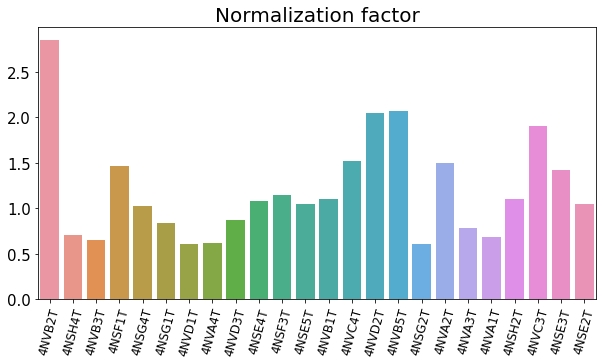

Normalization factor should be within 0.1 to 10 scale.
Otherwise those samples were removed from normalied data.


In [25]:
# If you want to remove the samples that does not pass QC uncomment below code
# sample = list(QC_filtered.index)
# sample.insert(0,"class")
# bc_count_filtered = bc_count[sample]
# bc_count_filtered
# Use bc_count_filtered instead of bc_count data

count_norm = utility.normalize_data(data = bc_count, method = "geCorr")

In [26]:
# Let's perform two sample t-test
print(utility.DE_analysis.__doc__)


    Input: df         > normalized count data with samples in columns and genes in row
           sample     > sample data
           sample_col > column from sample to do DE analysis, eg "treatment"
           group1     > numerator for log fold change example: "treated"
           group0     > denominator for log fold change example: "control"
           ttest      > "ind" >> independent wich is default
                        "pair" >> pairwise

    Output: data with logfold change, p_values and average counts over the groups
    


In [28]:
# Let's load the sample metadata
sample = pd.read_csv("../sample.csv", index_col = 0)
sample.head()

,treatment
4NVB2T,NV
4NSH4T,NS
4NVB3T,NV
4NSF1T,NS
4NSG4T,NS


In [29]:
stat = utility.DE_analysis(count_norm, sample, sample_col = "treatment", group1 = "NS", group0 = "NV", ttest = "ind")
stat

,lfc,t_value,p_value,fdr,Avg_NV,Avg_NS
CREB1,0.183813,1.602450,0.123318,0.854487,57.930359,65.802047
MYC,-0.071826,-0.666294,0.512151,0.939647,166.532316,158.444317
SAA1,-0.487160,-1.219354,0.235622,0.939647,38.147041,27.215163
RAET1,-0.262042,-0.523087,0.606143,0.939647,16.806951,14.015426
CARD11,-0.264749,-0.414759,0.682335,0.939647,16.380663,13.634336
...,...,...,...,...,...,...
ITGB1,-0.100896,-0.569869,0.574541,0.939647,628.852923,586.376096
MAP3K1,0.125126,1.160392,0.258327,0.939647,26.745234,29.168432
CTSH,-0.173018,-1.149335,0.262760,0.939647,85.578465,75.906847
IL12RB1,-0.264749,-0.414759,0.682335,0.939647,16.380663,13.634336


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/py_nsolver/utility.py:445: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sig1 = list(data2[(data2.p_value < 0.05) &  (data.lfc> 1)].index)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/py_nsolver/utility.py:447: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sig2 = list(data2[(data2.p_value < 0.05) &  (data.lfc < -1)].index)


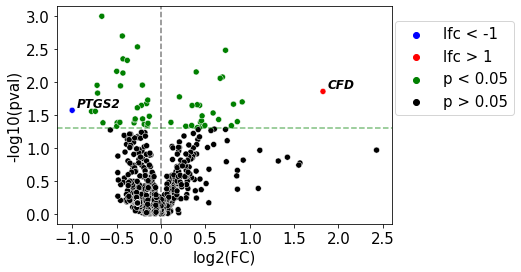

None


In [30]:
# Let's plot volcano
print(utility.plot_volcano(stat))

# Figure will be saved in the current directory